In [1]:
import os
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset, load_from_disk
from transformers import GPT2LMHeadModel, GPT2Config, GPT2TokenizerFast, Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback, pipeline
from transformers.integrations import TensorBoardCallback
from tokenizers import ByteLevelBPETokenizer
from tokenizers import Tokenizer, Regex, models, trainers, normalizers, pre_tokenizers, decoders, processors
from tokenizers.normalizers import Sequence, NFKC, Replace, Prepend
from tokenizers.pre_tokenizers import ByteLevel, Split, Whitespace
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.processors import TemplateProcessing
from itertools import chain
import glob

In [ ]:
'''
!pip install --user transformers==4.44.2 --no-deps
!pip install --user tokenizers==0.19.1 --no-deps
!pip install --user huggingface-hub==0.23.4 --no-deps
'''

In [2]:
import huggingface_hub
import tokenizers
import transformers
import torch

print("huggingface-hub version:", huggingface_hub.__version__)
print("tokenizers version:", tokenizers.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)

huggingface-hub version: 0.30.2
tokenizers version: 0.21.1
transformers version: 4.51.3
torch version: 2.1.2+cu121


In [13]:
# Set your source folder and output file
#output_file = "gpt2-small/corpus_data/10M_corpus.txt"
output_file = "gpt2-small/corpus_data/100M_corpus.txt"

# Match both .txt and .train files
file_paths = glob.glob(os.path.join('gpt2-small/corpus_data/CHILDES_data/', '*.txt')) + \
             glob.glob(os.path.join('gpt2-small/corpus_data/BabyLM_train_100M/', '*.train'))

# Write them into a combined file
with open(output_file, "w", encoding = "utf-8") as outfile:
    for path in file_paths:
        with open(path, "r", encoding = "utf-8") as infile:
            text = infile.read().strip()
            outfile.write(text + "\n\n")  # double newline separates files

In [3]:
#corpus_file = "gpt2-small/corpus_data/10M_corpus.txt"
corpus_file = "gpt2-small/corpus_data/100M_corpus.txt"
tokenizer_dir = "gpt2-small/tokenizer"
os.makedirs(tokenizer_dir, exist_ok = True)

# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE())

# Add Normalization (Unicode + formatting cleanup)
tokenizer.normalizer = Sequence([
    Prepend(" "),
    NFKC(),
    Replace(Regex("\n"), "\n "),
    Replace(Regex(" *\n"), "\n"),
])

# Add Pre-tokenizer (Unicode-aware + byte-level + max length split)
'''
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    #Split(
    #    Regex(r"[^\\r\\n\\p{L}\\p{N}]?[\\p{Lu}\\p{Lt}\\p{Lm}\\p{Lo}\\p{M}]*[\\p{Ll}\\p{Lm}\\p{Lo}\\p{M}]+|[^\\r\\n\\p{L}\\p{N}]?[\\p{Lu}\\p{Lt}\\p{Lm}\\p{Lo}\\p{M}]+[\\p{Ll}\\p{Lm}\\p{Lo}\\p{M}]*| ?\\p{N}| ?[^\\s\\p{L}\\p{N}]+[\\r\\n/]*|\\s*[\\r\\n]+|\\s+(?!\\S)|\\s+"),
    #    behavior = "isolated"),
    ByteLevel(add_prefix_space = False, use_regex = False, trim_offsets = True),
    #Split(Regex(".{1,24}"), behavior = "isolated")
])
'''
tokenizer.pre_tokenizer = Whitespace()

# Add Decoder (to reverse tokenization)
tokenizer.decoder = decoders.Sequence([
    ByteLevelDecoder(add_prefix_space = False, use_regex = False),
    decoders.Strip(" ", 1, 0),
    decoders.Replace("\n ", "\n"),
])

# Add Post-processor (for start-of-text markers)
#start_token = "<s>"
#tokenizer.post_processor = TemplateProcessing(
#    single = f"{start_token} $A",
#    pair = f"{start_token} $A {start_token} $B",
#    special_tokens = [(start_token, 1)]
#)
tokenizer.post_processor = processors.ByteLevel(trim_offsets = False)

# Train tokenizer
trainer = trainers.BpeTrainer(
    vocab_size = 50257,
    min_frequency = 2,
    #special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
)
tokenizer.train(files = [corpus_file], trainer = trainer)

# Save the tokenizer (as tokenizer.json)
tokenizer.save(os.path.join(tokenizer_dir, "tokenizer.json"))

In [4]:
# Load tokenizer with HuggingFace wrapper
#tokenizer = GPT2TokenizerFast(tokenizer_file = "gpt2-small/tokenizer/tokenizer.json")
tokenizer = GPT2TokenizerFast(tokenizer_file = "gpt2-small/checkpoint-trainedtokenizer_100M_whitespace/tokenizer.json")
#tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
# Optional: set pad token if using Trainer API or batches
tokenizer.pad_token = tokenizer.eos_token

# Load your dataset (can also use raw text)
#dataset = load_dataset("text", data_files = {"train": "gpt2-small/corpus_data/10M_corpus.txt"})
dataset = load_dataset("text", data_files = {"train": "gpt2-small/corpus_data/100M_corpus.txt"})
dataset = dataset['train'].train_test_split(test_size = 0.1, shuffle = True) 

'''
# Tokenize the dataset
def tokenize(example):
    return tokenizer(example["text"], truncation = True, padding = "max_length", max_length = 2048)
dataset = dataset.map(tokenize, batched = True, remove_columns = ["text"])
dataset.set_format(type = "torch", columns = ["input_ids", "attention_mask"])
'''

# Tokenize each example (no truncation, no padding)
def tokenize(example):
    return tokenizer(example["text"])

tokenized_dataset = dataset.map(tokenize, batched = True, remove_columns = ["text"], num_proc = 4)

# Save tokenized dataset for reuse (use load_from_disk latter)
tokenized_dataset.save_to_disk("gpt2-small/corpus_data/tokenized_dataset")

# Concatenate all input_ids and attention masks into single token streams
def concat(examples):
    examples["input_ids"]=[list(chain.from_iterable(examples['input_ids']))] # convert chain to list of tokens
    examples["attention_mask"]=[list(chain.from_iterable(examples['attention_mask']))] # convert chain to list of tokens
    
    return  examples

concated_dataset = tokenized_dataset.map(concat, batched = True, batch_size = 1000000, num_proc = 4)

# Chunk into fixed-size blocks (1024 tokens, GPT-2 style)
def chunk(examples):
    chunk_size = 1024 # modify this accordingly       
    input_ids = examples["input_ids"][0] # List[List], pass the inner list      
    attention_mask = examples["attention_mask"][0] # List[List]
    input_ids_truncated = []
    attention_mask_truncated = []
    
    # slice with step_size = chunk_size
    for i in range(0,len(input_ids),chunk_size):
        chunk = input_ids[i : i + chunk_size]
        if len(chunk) == chunk_size: # drop the last chunk if not equal
            input_ids_truncated.append(chunk)
            attention_mask_truncated.append(attention_mask[i : i + chunk_size])     
    examples['input_ids'] = input_ids_truncated
    examples["attention_mask"] = attention_mask_truncated
        
    return examples

chunked_dataset = concated_dataset.map(chunk, batched = True, batch_size = 2, num_proc = 2)

# Save the final preprocessed dataset for model training
chunked_dataset.save_to_disk("gpt2-small/corpus_data/chunked_dataset")
#chunked_dataset = load_from_disk("gpt2-small/corpus_data/chunked_dataset")

Using custom data configuration default-579f5123b37f862e
Reusing dataset text (/home/stellacy/.cache/huggingface/datasets/text/default-579f5123b37f862e/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)
Loading cached split indices for dataset at /home/stellacy/.cache/huggingface/datasets/text/default-579f5123b37f862e/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5/cache-cfe1a9ce64f2b511.arrow and /home/stellacy/.cache/huggingface/datasets/text/default-579f5123b37f862e/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5/cache-f16c4cbd16ca3f72.arrow
Parameter 'function'=<function tokenize at 0x150be2095d30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to b

 #0:   0%|          | 0/1619 [00:00<?, ?ba/s]

Parameter 'function'=<function tokenize at 0x150c304f4b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #1:   0%|          | 0/1619 [00:00<?, ?ba/s]

Parameter 'function'=<function tokenize at 0x150be206e670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #2:   0%|          | 0/1619 [00:00<?, ?ba/s]

Parameter 'function'=<function tokenize at 0x150be2095d30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #3:   0%|          | 0/1619 [00:00<?, ?ba/s]

Parameter 'function'=<function tokenize at 0x150c304f4b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function tokenize at 0x150beff3d8b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once.

 #0:   0%|          | 0/180 [00:00<?, ?ba/s]

 #1:   0%|          | 0/180 [00:00<?, ?ba/s]

 #3:   0%|          | 0/180 [00:00<?, ?ba/s]

 #2:   0%|          | 0/180 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x150d0914cb80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #0:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x150d0914cb80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #1:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x150d0914cb80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #2:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x150d0914cb80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #3:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x150c304f4b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function concat at 0x150c304f4b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Sub

 #0:   0%|          | 0/1 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x150c304f4b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function concat at 0x150c304f4b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Sub

 #1:   0%|          | 0/1 [00:00<?, ?ba/s]

 #2:   0%|          | 0/1 [00:00<?, ?ba/s]

 #3:   0%|          | 0/1 [00:00<?, ?ba/s]

Parameter 'function'=<function chunk at 0x150beff3dd30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function chunk at 0x150beff3ddc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subse

 #0:   0%|          | 0/2 [00:00<?, ?ba/s]

 #1:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function chunk at 0x150beff3d8b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function chunk at 0x150beff3dd30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subse

 #1:   0%|          | 0/1 [00:00<?, ?ba/s]

 #0:   0%|          | 0/1 [00:00<?, ?ba/s]

In [5]:
# Load model config and model
#config = GPT2Config.from_json_file("gpt3_small_config.json")
config = GPT2Config()
'''
config = GPT2Config(
    vocab_size = 50257,
    n_positions = 1024, # GPT-2 context length
    n_ctx = 1024,
    n_embd = 768,
    n_layer = 12,
    n_head = 12,
    
    # GPT-3 uses no dropout during pretraining
    resid_pdrop = 0.1, # 0.0 for GPT-3
    embd_pdrop = 0.1, # 0.0 for GPT-3
    attn_pdrop = 0.1, # 0.0 for GPT-3
    
    activation_function = "gelu_new",
    layer_norm_epsilon = 1e-5,
    initializer_range = 0.02,
    bos_token_id = 50256,
    eos_token_id = 50256,
    use_cache = True,
    scale_attn_weights = True,
    scale_attn_by_inverse_layer_idx = False,
    reorder_and_upcast_attn = False,
)
'''

model = GPT2LMHeadModel(config)

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, pad_to_multiple_of = None, mlm = False)

# Training arguments
training_args = TrainingArguments(
    #output_dir = "./gpt2-small",
    output_dir = "./gpt2-100M",
    #evaluation_strategy = "no",
    #eval_strategy = "no",
    eval_strategy = "steps",
    eval_steps = 100,
    logging_strategy = "steps",
    logging_steps = 100,
    save_strategy = "steps",
    save_steps = 1000,
    save_total_limit = 2,
    num_train_epochs = 10,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 16,
    learning_rate = 5e-4, #5e-4 ~ 6e-4 for GPT-2
    warmup_ratio = 0.1,
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",
    adam_beta1 = 0.9,
    adam_beta2 = 0.999, #0.95 for GPT-3
    fp16 = True,
    logging_dir = "./gpt2-small/logs", #GPT-2 uses cross-entropy loss
    report_to = "tensorboard", 
    load_best_model_at_end = True,
)

# Initialize Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    tokenizer = tokenizer,
    train_dataset = chunked_dataset['train'],
    eval_dataset = chunked_dataset['test'],
    data_collator = data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)],
    #callbacks = [TensorBoardCallback()],
)

#%load_ext tensorboard
#%tensorboard --logdir ./gpt2-small/logs

# Train the model
trainer.train()


/tmp/ipykernel_1643585/1533955730.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
100,9.461600,8.405389
200,7.574000,6.736331
300,6.387000,6.157678
400,6.064400,5.965590
500,5.918300,5.850304
600,5.829600,5.773889
700,5.752500,5.699870
800,5.676900,5.592299
900,5.564500,5.469193
1000,5.438400,5.356067


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=10600, training_loss=4.5415319881799086, metrics={'train_runtime': 17966.5048, 'train_samples_per_second': 30.865, 'train_steps_per_second': 1.929, 'total_flos': 8.8627121750016e+16, 'train_loss': 4.5415319881799086, 'epoch': 3.058282540484005})

In [16]:
from torch.utils.tensorboard import SummaryWriter

# Create a TensorBoard writer
writer = SummaryWriter(log_dir="./gpt2-small/logs_reconstructed")  # different folder to avoid conflicts

# Recorded steps and losses
steps_losses = [
    (100, 4.837000),
    (200, 4.329800),
    (300, 4.097600),
    (400, 3.957800),
    (500, 3.815600),
    (600, 3.725500),
    (700, 3.647400),
    (800, 3.586900),
    (900, 3.545300),
    (1000, 3.502600),
    (1100, 3.490900),
    (1200, 3.419700),
    (1300, 3.402200),
    (1400, 3.366500),
    (1500, 3.350200),
    (1600, 3.325200),
    (1700, 3.299500),
    (1800, 3.296800),
    (1900, 3.272900),
    (2000, 3.258100),
    (2100, 3.238700),
    (2200, 3.246000),
    (2300, 3.182000),
    (2400, 3.154400),
    (2500, 3.165500),
    (2600, 3.153200),
    (2700, 3.138400),
    (2800, 3.133300),
    (2900, 3.125500),
    (3000, 3.129700),
    (3100, 3.124900),
    (3200, 3.110600),
]

# Log each step and loss
for step, loss in steps_losses:
    writer.add_scalar("train/loss", loss, step)

# Close the writer to flush files
writer.close()

In [22]:
#model = GPT2LMHeadModel.from_pretrained('gpt2-small/checkpoint-pretrainedtokenizer_100M')
model = GPT2LMHeadModel.from_pretrained('gpt2-small/checkpoint-trainedtokenizer_100M')
#tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer = GPT2TokenizerFast(tokenizer_file = "gpt2-small/checkpoint-trainedtokenizer_100M/tokenizer.json")

In [22]:
generator = pipeline("text-generation", model = model, tokenizer = tokenizer)
print(generator("Once upon a time", max_length = 50, do_sample = True, top_k = 50))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': "Once upon a times saw sal down that's this bister it's a press so what does this she si this"}]


Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
Training Loss Tag: train/loss
Evaluation Loss Tag: eval/loss


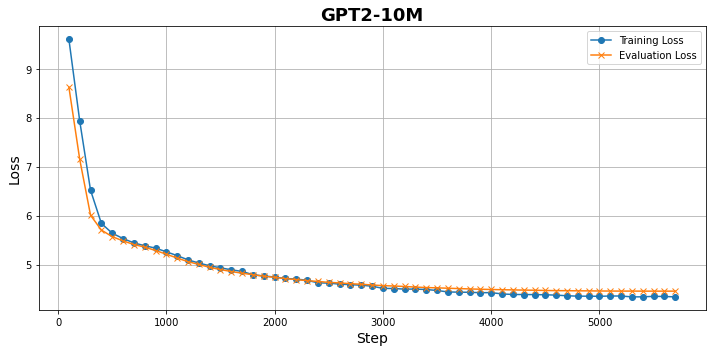

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt2-small/logs'
event_path = os.path.join(log_dir, 'events.out.tfevents.gpt2.10M')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

training_loss_tag = None
evaluation_loss_tag = None
possible_training_tags = ["loss", "train/loss", "training_loss"]
possible_evaluation_tags = ["eval/loss", "validation_loss", "validation/loss"]

# find the training loss tag
for t in possible_training_tags:
    if t in event_acc.Tags()["scalars"]:
        training_loss_tag = t
        print(f"Training Loss Tag: {training_loss_tag}")
        break

# find the evaluation loss tag
for t in possible_evaluation_tags:
    if t in event_acc.Tags()["scalars"]:
        evaluation_loss_tag = t
        print(f"Evaluation Loss Tag: {evaluation_loss_tag}")
        break

# ensure both tags were found
assert training_loss_tag, f"Could not find expected training loss tag. Found: {event_acc.Tags()['scalars']}"
assert evaluation_loss_tag, f"Could not find expected evaluation loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data for training loss
train_events = event_acc.Scalars(training_loss_tag)
train_steps = [e.step for e in train_events]
train_values = [e.value for e in train_events]

# extract data for evaluation loss
eval_events = event_acc.Scalars(evaluation_loss_tag)
eval_steps = [e.step for e in eval_events]
eval_values = [e.value for e in eval_events]

# plotting both training and evaluation loss
plt.figure(figsize = (10, 5))
plt.plot(train_steps, train_values, marker = "o", label = "Training Loss")
plt.plot(eval_steps, eval_values, marker = "x", label = "Evaluation Loss")
plt.xlabel("Step", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.title("GPT2-10M", fontsize = 18, weight = 'bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
Training Loss Tag: train/loss
Evaluation Loss Tag: eval/loss


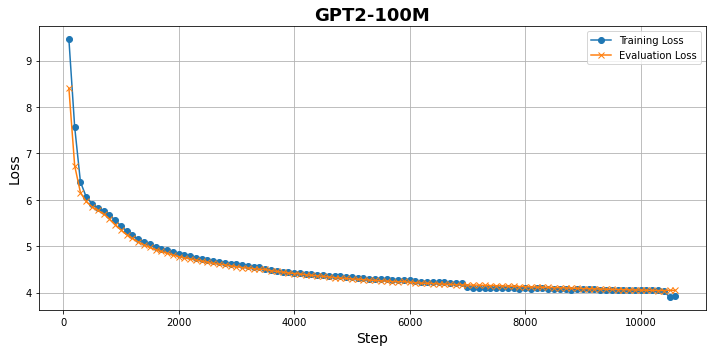

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt2-small/logs'
event_path = os.path.join(log_dir, 'events.out.tfevents.gpt2.100M')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

training_loss_tag = None
evaluation_loss_tag = None
possible_training_tags = ["loss", "train/loss", "training_loss"]
possible_evaluation_tags = ["eval/loss", "validation_loss", "validation/loss"]

# find the training loss tag
for t in possible_training_tags:
    if t in event_acc.Tags()["scalars"]:
        training_loss_tag = t
        print(f"Training Loss Tag: {training_loss_tag}")
        break

# find the evaluation loss tag
for t in possible_evaluation_tags:
    if t in event_acc.Tags()["scalars"]:
        evaluation_loss_tag = t
        print(f"Evaluation Loss Tag: {evaluation_loss_tag}")
        break

# ensure both tags were found
assert training_loss_tag, f"Could not find expected training loss tag. Found: {event_acc.Tags()['scalars']}"
assert evaluation_loss_tag, f"Could not find expected evaluation loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data for training loss
train_events = event_acc.Scalars(training_loss_tag)
train_steps = [e.step for e in train_events]
train_values = [e.value for e in train_events]

# extract data for evaluation loss
eval_events = event_acc.Scalars(evaluation_loss_tag)
eval_steps = [e.step for e in eval_events]
eval_values = [e.value for e in eval_events]

# plotting both training and evaluation loss
plt.figure(figsize = (10, 5))
plt.plot(train_steps, train_values, marker = "o", label = "Training Loss")
plt.plot(eval_steps, eval_values, marker = "x", label = "Evaluation Loss")
plt.xlabel("Step", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.title("GPT2-100M", fontsize = 18, weight = 'bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
